In [1]:
import numpy as np

import qcodes as qc

## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)

## Using interactive widget
from qcodes.interactive_widget import experiments_widget

## Dummy instruments for generating synthetic data
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)

In [2]:
# A dummy signal generator with two parameters ch1 and ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy digital multimeter that generates a synthetic data depending
# on the values set on the setter_instr, in this case the dummy dac
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

In [3]:
dmm.print_readable_snapshot()

dmm:
	parameter value
--------------------------------------------------------------------------------
IDN :	None 
v1  :	0 (V)
v2  :	0 (V)


In [33]:
dac.ch1(1.1)

In [35]:
dmm.v1()

4.101750832165395

In [36]:
station = qc.Station()

In [37]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

In [38]:
# Remove the ``_ = `` part to see the full snapshot
_ = station.snapshot()

In [39]:
initialise_or_create_database_at("~/experiments_for_15_mins.db")

In [40]:
qc.config.core.db_location

'~/experiments_for_15_mins.db'

In [41]:
tutorial_exp = load_or_create_experiment(
    experiment_name="tutorial_exp",
    sample_name="synthetic data"
)

In [13]:
context_meas = Measurement(exp=tutorial_exp, station=station, name='context_example')

In [42]:
# Register the independent parameter...
context_meas.register_parameter(dac.ch1)
# ...then register the dependent parameter
context_meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

In [15]:
# Time for periodic background database writes
context_meas.write_period = 2

with context_meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 1. 


In [16]:
# Setting up a doNd measurement
sweep_1 = LinSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_2 = LinSweep(dac.ch2, -1, 1, 20, 0.01)

In [17]:
dond(
    sweep_1,                          # 1st independent parameter
    sweep_2,                          # 2nd independent parameter
    dmm.v1,                           # 1st dependent parameter
    dmm.v2,                           # 2nd dependent parameter
    measurement_name="dond_example",  # Set the measurement name
    exp=tutorial_exp,                 # Set the experiment to save data to.
    show_progress=True                # Optional progress bar
)

Starting experimental run with id: 2. Using 'qcodes.dataset.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

(dond_example #2@C:\Users\adiln\experiments_for_15_mins.db
 ---------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 (None,),
 (None,))

In [18]:
experiments()

[tutorial_exp#synthetic data#1@C:\Users\adiln\experiments_for_15_mins.db
 -----------------------------------------------------------------------
 1-context_example-1-dac_ch1,dmm_v1-10
 2-dond_example-2-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800]

In [19]:
tutorial_exp.data_sets()

[context_example #1@C:\Users\adiln\experiments_for_15_mins.db
 ------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 dond_example #2@C:\Users\adiln\experiments_for_15_mins.db
 ---------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric]

In [21]:
dataset_1d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=1)
dataset_2d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=2)

Trying to mark a run completed that was already completed.


([<Axes: title={'center': 'Run #1, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

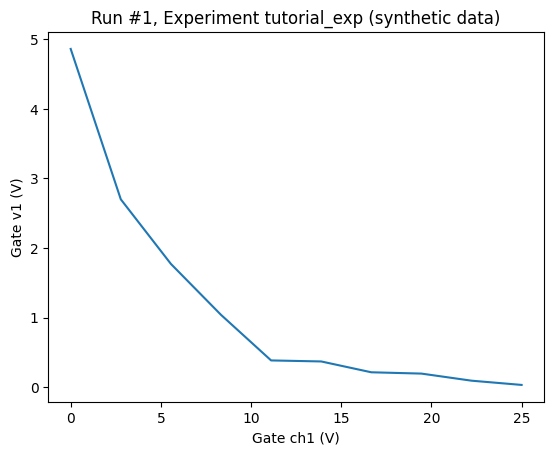

In [22]:
# Plotting 1d dataset
plot_dataset(dataset_1d)

Trying to mark a run completed that was already completed.


([<Axes: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <Axes: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x1b5ebde0c10>])

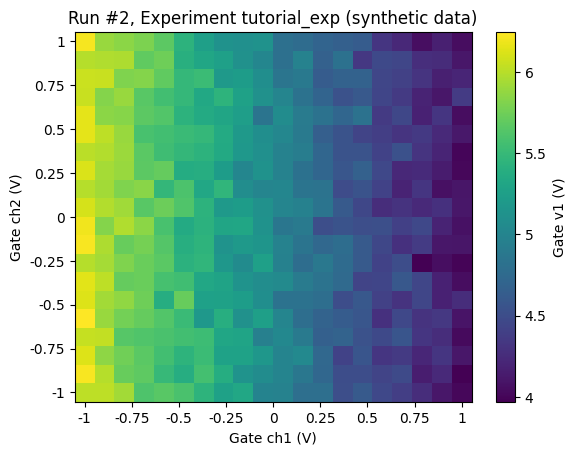

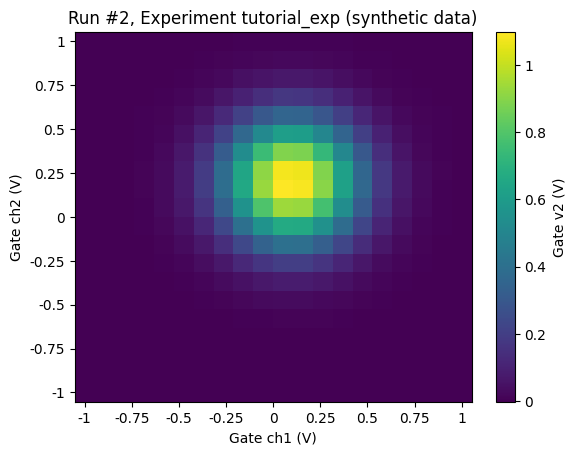

In [23]:
# Plotting 2d dataset as heatmaps
plot_dataset(dataset_2d)

In [24]:
# All data for all parameters
dataset_1d.get_parameter_data()

{'dmm_v1': {'dmm_v1': array([4.86086231, 2.69953177, 1.77117235, 1.03918111, 0.38395673,
         0.36934458, 0.21363186, 0.19484115, 0.09294899, 0.03200656]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [25]:
# Data for independent parameter
dataset_1d.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [26]:
# Data for dependent parameter
dataset_1d.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([4.86086231, 2.69953177, 1.77117235, 1.03918111, 0.38395673,
         0.36934458, 0.21363186, 0.19484115, 0.09294899, 0.03200656]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [27]:
df = dataset_1d.to_pandas_dataframe()
df.head()

,dmm_v1
dac_ch1,
0.000000,4.860862
2.777778,2.699532
5.555556,1.771172
8.333333,1.039181
11.111111,0.383957


In [28]:
xr_dataset = dataset_1d.to_xarray_dataset()
xr_dataset

<xarray.Dataset>
Dimensions:  (dac_ch1: 10)
Coordinates:
  * dac_ch1  (dac_ch1) float64 0.0 2.778 5.556 8.333 ... 16.67 19.44 22.22 25.0
Data variables:
    dmm_v1   (dac_ch1) float64 4.861 2.7 1.771 1.039 ... 0.1948 0.09295 0.03201
Attributes: (12/14)
    ds_name:                  context_example
    sample_name:              synthetic data
    exp_name:                 tutorial_exp
    snapshot:                 {"station": {"instruments": {"dac": {"functions...
    guid:                     36724b09-0000-0000-0000-0189fdef62f0
    run_timestamp:            2023-08-16 12:41:11
    ...                       ...
    captured_counter:         1
    run_id:                   1
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    parent_dataset_links:     []
    run_timestamp_raw:        1692182471.4290888
    completed_timestamp_raw:  1692182471.4340997

In [29]:
experiments_widget(sort_by="timestamp")